In [1]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision.io import read_image

import utils

%load_ext autoreload
%autoreload 2

from torchvision.transforms import functional as F

In [2]:
import torch

im = read_image('../data/collins.png') / 255
_, res, _ = im.shape

def manual_resize(im, res, kernel_size, sigma):
    # prefilter
    blurred = F.gaussian_blur(im, kernel_size, sigma)

    # sample points
    points = utils.image_points(res)

    im_downsampled = torch.zeros(3, res, res)
    for y in range(res):
        for x in range(res):
            coord = points[y, x]
            im_downsampled[:, y, x] = utils.sample_bilinear(blurred, coord)

    return blurred, im_downsampled

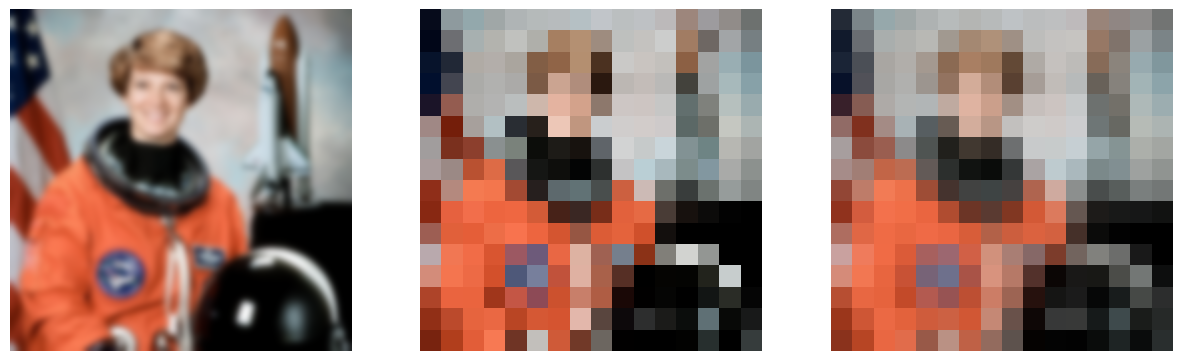

In [3]:
n_downsample = 16

truth = F.resize(im, n_downsample, antialias=True)
prefiltered, downsampled = manual_resize(im, n_downsample, kernel_size=101, sigma=5)

size = 15
fig, axs = plt.subplots(1, 3, figsize=(size, 3 * size))
axs[0].imshow(prefiltered.permute(1, 2, 0), extent=[0, 1, 1, 0])
axs[1].imshow(downsampled.permute(1, 2, 0), extent=[0, 1, 1, 0])
axs[2].imshow(truth.permute(1, 2, 0), extent=[0, 1, 1, 0])
for ax in axs:
    ax.axis('off')

In [4]:
from model import MLP
from enc import IPE
from experiment_util import ExperimentModel, train_models, default_training_settings

ipe = IPE(d_in=2, n_freqs=20)
model = ExperimentModel('IPE-multi', 'ipe-multi', MLP(d_input=ipe.d_output), ipe, 'collins-multi')
train_settings = default_training_settings()
train_models([model], train_settings, re_train=False)

In [5]:
from pipeline.evaluation import load_model

import wandb

api = wandb.Api()
trained_model = load_model(api.artifact(f'romeu/mip-NeRF2D/{model.artifact_name}:latest'))

wandb:   3 of 3 files downloaded.  


wandb:   1 of 1 files downloaded.  


In [0]:
from model_evaluation import nerf_forward

scales = np.linspace(0.01, 0.1, 10)
renders = [nerf_forward(trained_model.model, trained_model.enc, 512, scale) for scale in scales]

In [ ]:
from gaussian import Gaussian2D

size = 3
fig, axs = plt.subplots(2, len(scales), figsize=(2 * len(scales), 2 * size))

def scale_to_sigma(scale):
    g = Gaussian2D(0, np.array([scale, scale]), np.array([0, 0]))
    cov = g.covariance_matrix()
    sigma = np.diag(cov)[0]
    return 512 * sigma

for i, scale in enumerate(scales):
    ax_nerf = axs[0, i]
    ax_truth = axs[1, i]

    ax_nerf.imshow(renders[i].permute(1, 2, 0).detach().numpy())
    ax_truth.imshow(F.gaussian_blur(im, kernel_size=101, sigma=scale_to_sigma(scale)).permute(1, 2, 0))

plt.show()